Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).
- Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.
- Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.
- Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).
- Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана. Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.
- Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.
- Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.
- Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

[Эта часть задания не оценивается, здесь нет правильных и неправильных ответов, но буду рад узнать, что вы думаете]
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?


In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import scipy

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 6

### Загрузка и предобработка данных

In [2]:
# загрузим данные
df = pd.read_csv('full_data.csv')
df = df[(df['location'] == 'Russia') & (df['date'] >= '2020-03-03')].reset_index(drop=True)
df.loc[df['new_cases'] == 0, 'new_cases'] = 1
df['day'] = df.index

In [3]:
start_day = datetime.strptime('2020-03-03', '%Y-%m-%d')
may_first = datetime.strptime('2020-05-01', '%Y-%m-%d')
june_first = datetime.strptime('2020-06-01', '%Y-%m-%d')
sept_first = datetime.strptime('2020-09-01', '%Y-%m-%d')
year_end = datetime.strptime('2020-12-31', '%Y-%m-%d')

till_may = (may_first - start_day).days
till_june = (june_first - start_day).days
till_sept = (sept_first - start_day).days
till_year_end = (year_end - start_day).days

### Разделим на трейн и тест

In [4]:
# разделим на трейн и тест. Возьмем 60! дней, т.к. результаты получаются более адекватные
TRAIN_DAYS = 60

train = df[:TRAIN_DAYS]
test = df[TRAIN_DAYS:]

### Код для байесовской регрессии

In [5]:
class BayesLR(BaseEstimator, TransformerMixin):
    
    def __init__(self, mu, sigma, noise=None):
        self.mu = mu
        self.sigma = sigma
        self.noise = None
        
    def _estimate_noise(self, X, y):
        return np.std(y - X.dot(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y))) # linear regression
    
    def _add_intercept(self, X):
        return np.hstack((np.ones((len(X), 1)), X))
    
    def fit(self, X, y):
        """
        X: (n_samples, n_features)
        y: (n_samples, )
        """
        X = self._add_intercept(X)
        
        if self.noise is None:
            self.noise = self._estimate_noise(X, y)  
        beta = 1 / self.noise ** 2
        
        mu_prev = self.mu
        sigma_prev = self.sigma
        self.sigma = np.linalg.inv(np.linalg.inv(sigma_prev) + beta * np.dot(X.T, X))
        self.mu = np.dot(self.sigma, np.dot(np.linalg.inv(sigma_prev), mu_prev) + beta * np.dot(X.T, y))
        
        return self
        
    def predict(self, X):
        X = self._add_intercept(X)
        return X.dot(self.mu)
    
    def sample_w(self, n_samples=1000):
        return np.random.multivariate_normal(self.mu, self.sigma, n_samples)
    
    def sample(self, X, n_samples=1000):
        X = self._add_intercept(X)
        w = self.sample_w(n_samples)
        return X.dot(w.T)

In [6]:
def plot_sampled(sampled, true=None):
    for i in range(sampled.shape[1]):
        plt.plot(sampled[:, i], 'k-', lw=.4)

## Часть 1: моделирование экспонентной

### 1.1 Графики

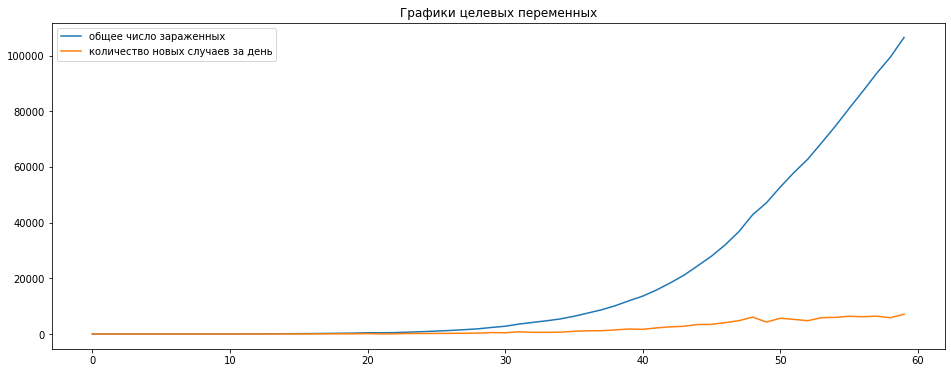

In [7]:
plt.plot(train['total_cases'], label='общее число зараженных')
plt.plot(train['new_cases'], label='количество новых случаев за день')
plt.title('Графики целевых переменных')
plt.legend();

### 1.2 Линейная регрессия y ~ exp(wX)

Чтобы построить линейную регрессию для такого случая, прологарифмируем целевую переменную (общее количество зараженных).

In [8]:
X_tr = train[['day']].values
y_tr = np.log(train['total_cases'].values)

X_te = test[['day']].values
y_te = np.log(test['total_cases'].values)

X_full = np.arange(till_year_end + 1).reshape(-1, 1) # до конца года

In [9]:
# Выберем uninformative prior
mu_prior = np.array([0, 0])
sigma_prior = 100 * np.array([[1, 0], 
                              [0, 1]])

bayes_lr = BayesLR(mu_prior, sigma_prior)
bayes_lr.fit(X_tr, y_tr)

print(bayes_lr.mu)
print(bayes_lr.sigma)

[1.81476765 0.18447833]
[[ 1.70391846e-02 -4.29559261e-04]
 [-4.29559261e-04  1.45619669e-05]]


In [10]:
# Семплируем параметры модели
w = bayes_lr.sample_w(n_samples=10000)

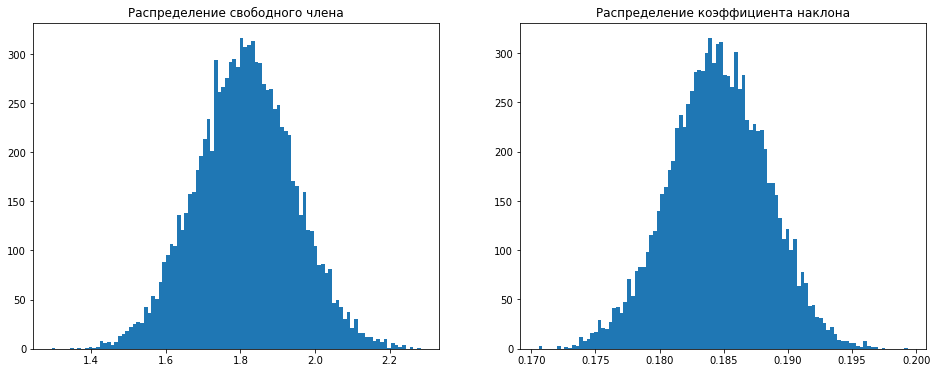

In [11]:
fig, ax = plt.subplots(1, 2)

ax[0].hist(w[:, 0], bins=100)
ax[0].set_title('Распределение свободного члена')

ax[1].hist(w[:, 1], bins=100)
ax[1].set_title('Распределение коэффициента наклона')

plt.show()

### 1.3 Предсказания

In [12]:
# Семплируем экспоненты для трейна
sampled_train = np.exp(bayes_lr.sample(X_tr))

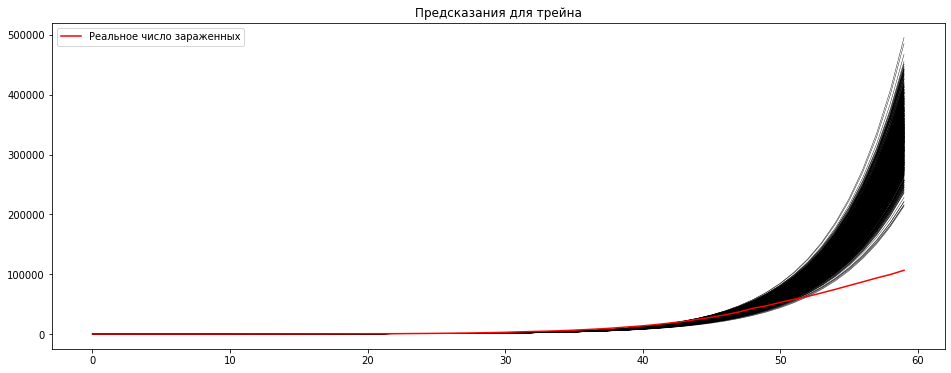

In [13]:
plot_sampled(sampled_train)
plt.plot(np.exp(y_tr), color='red', label='Реальное число зараженных')
plt.legend()
plt.title('Предсказания для трейна');

In [14]:
# Посемплируем экспоненты для теста
sampled_test = np.exp(bayes_lr.sample(X_te, n_samples=10000))

# Делаем предсказания
preds_full = np.exp(bayes_lr.predict(X_full))

1 мая: 0.3274 млн зараженных
1 июня: 99.7141 млн зараженных
1 сентября: 2342098539.3834 млн зараженных


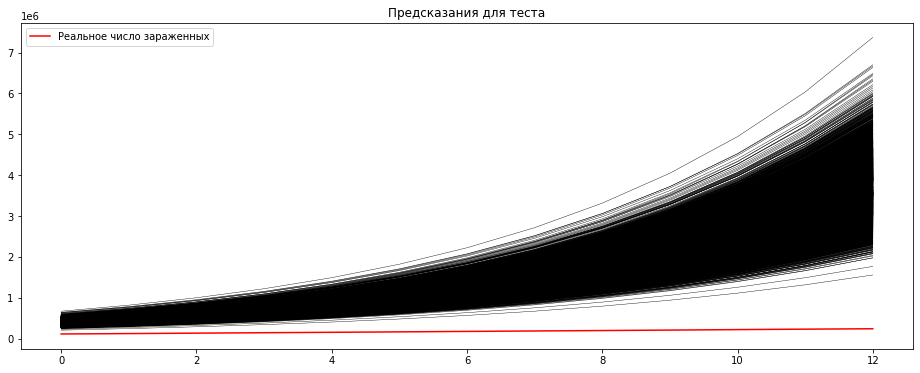

In [15]:
plot_sampled(sampled_test)
plt.plot(np.exp(y_te), color='red', label='Реальное число зараженных')
plt.legend()
plt.title('Предсказания для теста');

print(f'1 мая: {preds_full[till_may] / 1_000_000:.4f} млн зараженных')
print(f'1 июня: {preds_full[till_june] / 1_000_000:.4f} млн зараженных')
print(f'1 сентября: {preds_full[till_sept] / 1_000_000:.4f} млн зараженных')

Получается, что к 1 июня 2/3 России вымрет, не очень реалистично.

In [16]:
# Посемплируем экспоненты на будущее
sampled_full = np.exp(bayes_lr.sample(X_full, n_samples=10000))

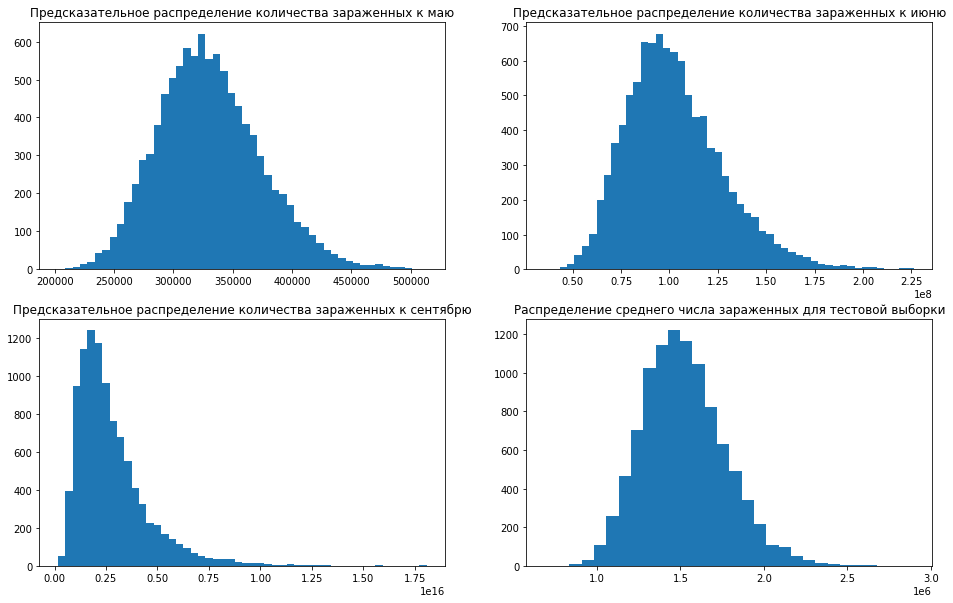

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

ax[0][0].hist(sampled_full[till_may], bins=50)
ax[0][0].set_title('Предсказательное распределение количества зараженных к маю')

ax[0][1].hist(sampled_full[till_june], bins=50)
ax[0][1].set_title('Предсказательное распределение количества зараженных к июню')

ax[1][0].hist(sampled_full[till_sept], bins=50)
ax[1][0].set_title('Предсказательное распределение количества зараженных к сентябрю')

ax[1][1].hist(sampled_test.mean(0), bins=30)
ax[1][1].set_title('Распределение среднего числа зараженных для тестовой выборки')

plt.show()

Вывод: моделирование экспонентой - это шляпа =)

## Часть 2: моделирование сигмоидой

### 2.1 Как такое обучать

Справа у нас интеграл - можем взять производную, а затем прологарифмировать, в итоге получим:

$ln$($\Delta$y) = w_2 * x^2 + w_1 * x + w_0 

Другими словами, мы можем замоделировать количество новых случаев заражения с помощью плотности нормального распределения. В качестве функции в экспоненте возьмет квадратичную функцию от дня.

### 2.2 Обучаем

In [18]:
# Функция для приведения наших предсказаний приростов к общему числу зараженных
def to_total(preds):
    return 2 + np.cumsum(np.exp(preds), axis=0)

In [19]:
X_tr = np.hstack([X_tr, X_tr ** 2])
y_tr = np.log(train['new_cases'].values)

X_te = np.hstack([X_te, X_te ** 2])
y_te = np.log(test['new_cases'].values)

X_full = np.hstack([X_full, X_full ** 2])

In [20]:
# Выберем uninformative prior
mu_prior = np.array([0, 0, 0])
sigma_prior = 1000 * np.array([[1, 0, 0], 
                               [0, 1, 0],
                               [0, 0, 1]])

bayes_lr = BayesLR(mu_prior, sigma_prior)
bayes_lr.fit(X_tr, y_tr)

print(bayes_lr.mu)
print(bayes_lr.sigma)

[-0.7822012   0.28569776 -0.00200843]
[[ 7.54223479e-02 -5.06981264e-03  7.10057749e-05]
 [-5.06981264e-03  4.63235833e-04 -7.34561947e-06]
 [ 7.10057749e-05 -7.34561947e-06  1.24503088e-07]]


In [21]:
# Семплируем параметры модели
w = bayes_lr.sample_w(n_samples=10000)

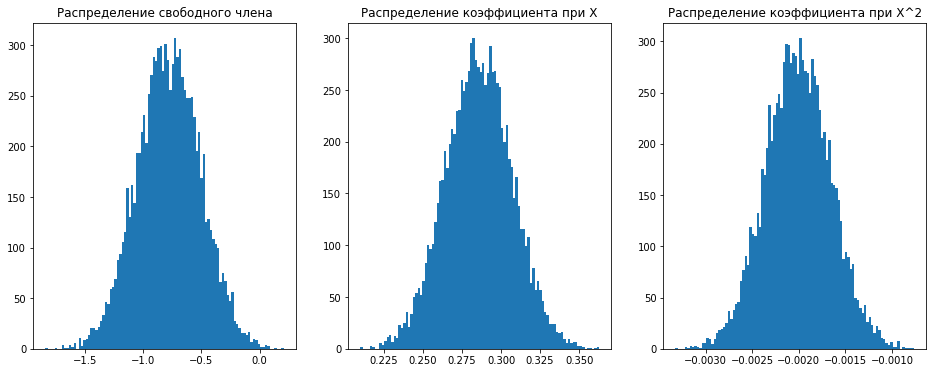

In [22]:
fig, ax = plt.subplots(1, 3)

ax[0].hist(w[:, 0], bins=100)
ax[0].set_title('Распределение свободного члена')

ax[1].hist(w[:, 1], bins=100)
ax[1].set_title('Распределение коэффициента при X')

ax[2].hist(w[:, 2], bins=100)
ax[2].set_title('Распределение коэффициента при X^2')

plt.show()

### 2.3 Предсказываем

In [23]:
# Семплируем сигмоиды для трейна
sampled_train = to_total(bayes_lr.sample(X_tr))

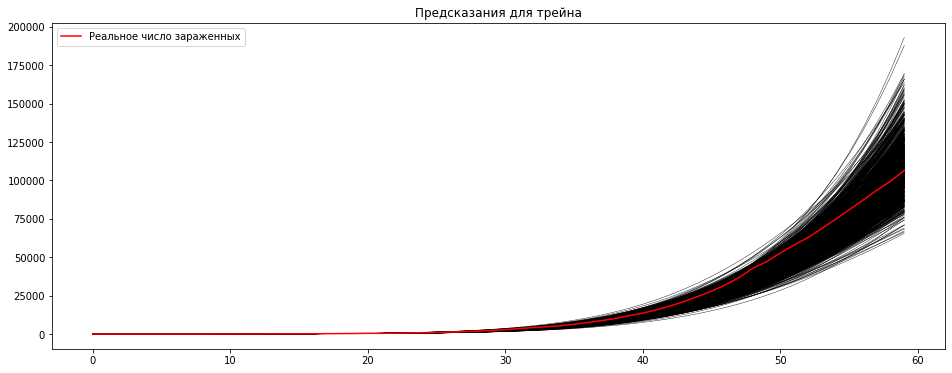

In [24]:
plot_sampled(sampled_train)
plt.plot(to_total(y_tr), color='red', label='Реальное число зараженных')
plt.legend()
plt.title('Предсказания для трейна');

In [25]:
# Посемплируем сигмоиды для теста
sampled_test = to_total(bayes_lr.sample(X_te))

# Делаем предсказания
preds_full = to_total(bayes_lr.predict(X_full))

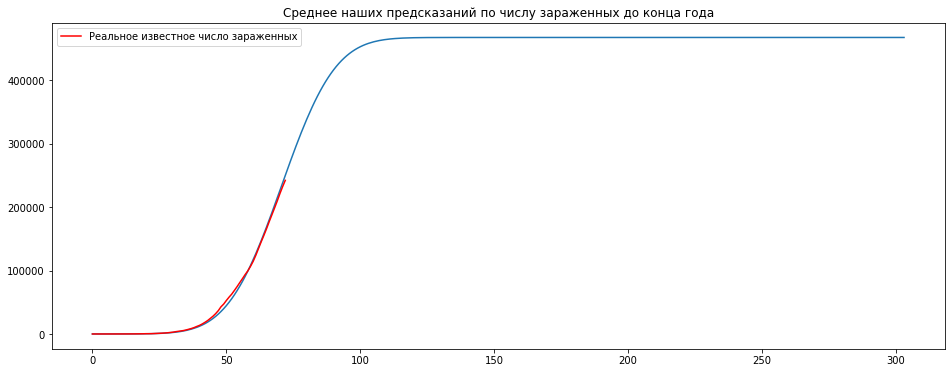

In [26]:
plt.plot(preds_full)
plt.plot(to_total(np.hstack([y_tr, y_te])), color='red', label='Реальное известное число зараженных')
plt.legend()
plt.title('Среднее наших предсказаний по числу зараженных до конца года');

1 мая: 0.1078 млн зараженных
1 июня: 0.4163 млн зараженных
1 сентября: 0.4676 млн зараженных


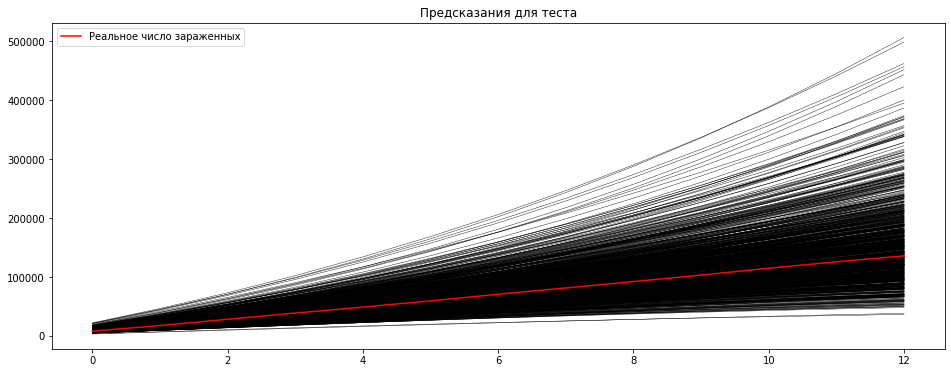

In [27]:
plot_sampled(sampled_test)
plt.plot(to_total(y_te), color='red', label='Реальное число зараженных')
plt.legend()
plt.title('Предсказания для теста');

print(f'1 мая: {preds_full[till_may] / 1_000_000:.4f} млн зараженных')
print(f'1 июня: {preds_full[till_june] / 1_000_000:.4f} млн зараженных')
print(f'1 сентября: {preds_full[till_sept] / 1_000_000:.4f} млн зараженных')

In [28]:
# Посемплируем сигмоиды на будущее
sampled_full = to_total(bayes_lr.sample(X_full, n_samples=100))

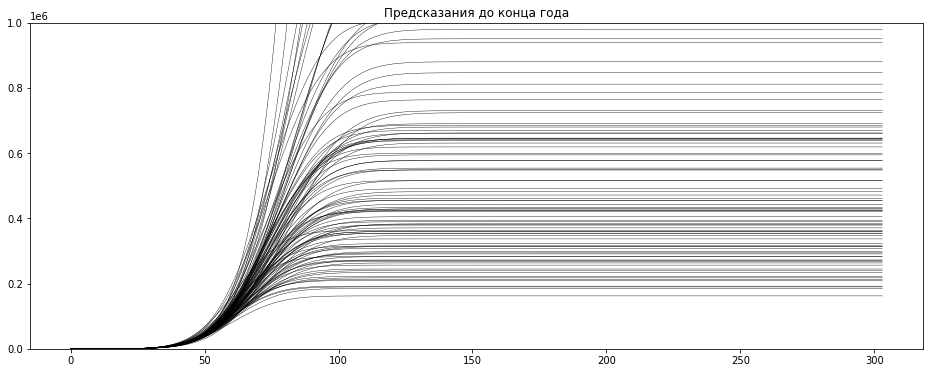

In [29]:
plot_sampled(sampled_full)
plt.ylim(0, 1_000_000)
plt.title('Предсказания до конца года');

In [30]:
# Посемплируем больше сигмоид на будущее
sampled_full = to_total(bayes_lr.sample(X_full, n_samples=10000))

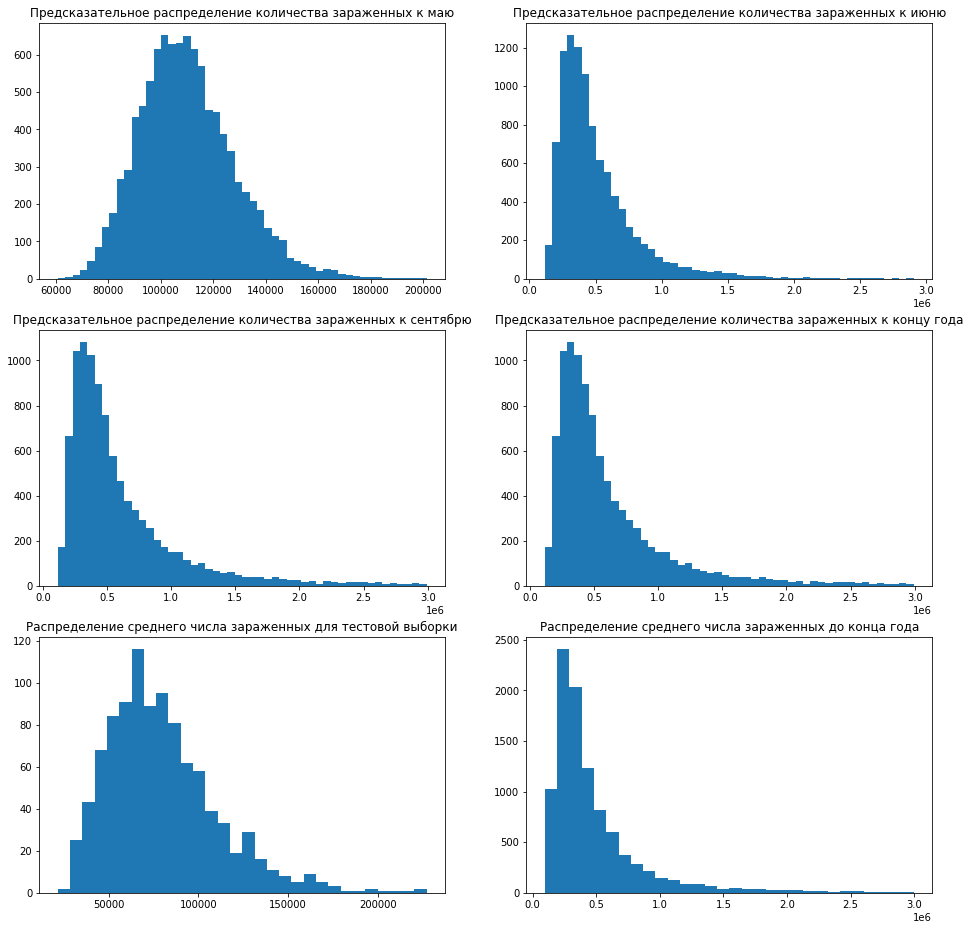

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(16, 16))

SHOW_THR = 3_000_000

ax[0][0].hist(sampled_full[till_may], bins=50)
ax[0][0].set_title('Предсказательное распределение количества зараженных к маю')

ax[0][1].hist(sampled_full[till_june][sampled_full[till_june] < SHOW_THR], bins=50)
ax[0][1].set_title('Предсказательное распределение количества зараженных к июню')

ax[1][0].hist(sampled_full[till_sept][sampled_full[till_sept] < SHOW_THR], bins=50)
ax[1][0].set_title('Предсказательное распределение количества зараженных к сентябрю')

ax[1][1].hist(sampled_full[-1][sampled_full[-1] < SHOW_THR], bins=50)
ax[1][1].set_title('Предсказательное распределение количества зараженных к концу года')

ax[2][0].hist(sampled_test.mean(0), bins=30)
ax[2][0].set_title('Распределение среднего числа зараженных для тестовой выборки')

ax[2][1].hist(sampled_full.mean(0)[sampled_full.mean(0) < SHOW_THR], bins=30)
ax[2][1].set_title('Распределение среднего числа зараженных до конца года')

plt.show()

In [32]:
print(f'Оптимистичный прогноз к концу года: {int(np.quantile(sampled_full[-1], 0.1)) / 1_000_000:.4f} млн человек')
print(f'Пессимистичный прогноз к концу года: {int(np.quantile(sampled_full[-1], 0.9)) / 1_000_000:.4f} млн человек')

Оптимистичный прогноз к концу года: 0.2409 млн человек
Пессимистичный прогноз к концу года: 1.3295 млн человек


Если смотреть на пессимистичный прогноз, то он кажется уже чуть более реальным.

#### Что я понял

- Разобрался с байесовским выводом, понял (надеюсь), как обучать сигмоиды
- Параметры априорных распределений не играют большой роли, когда имеется уже 50 точек
- Моделировать экспонентой - шляпа, сигмоидой получше, хотя такие модели кажутся здесь все равно слишком неточными, и почти все зависит от выбора точки начала и конца моделирования
- Решение вводить или не вводить карантин, наверное, можно принять, оценив результат от его введения (быстрее ли затухает сигмоида) в других странах